In [1]:
%load_ext autoreload
%autoreload 2
%run nnn/ipynb_init.py
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import os, json
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import warnings
warnings.filterwarnings("ignore")
from nnn.uv import *

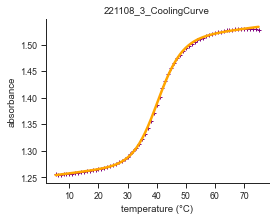

In [122]:
# for debugging
# datadir="./data/uv_melt/ECLExport"
# data_list = [fn for fn in absolute_file_paths(datadir) if fn.endswith('.csv')]
# result_dict = fit_curve(data_list[10], 
#                         figdir=os.path.join(datadir, 'fig'), debug=True)

In [2]:
sample_sheet_file = './data/uv_melt/ECLSampleSheet221116.csv'

100%|█████████████████████████████████████████| 304/304 [01:27<00:00,  3.49it/s]


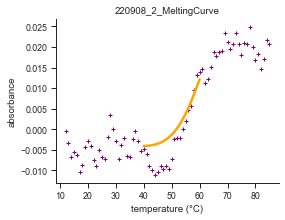

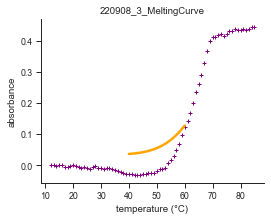

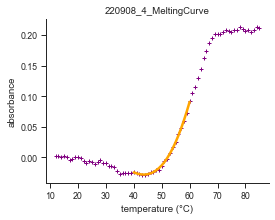

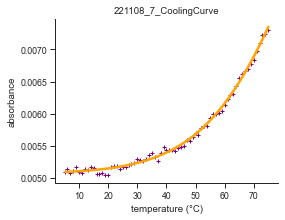

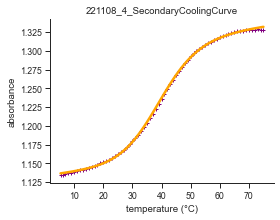

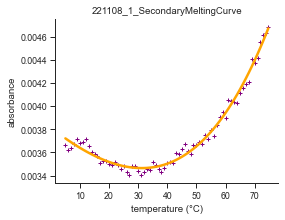

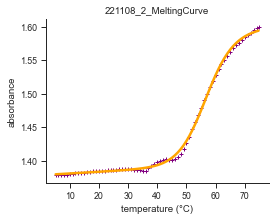

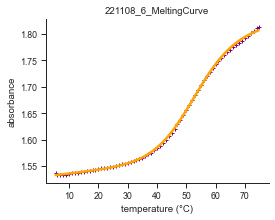

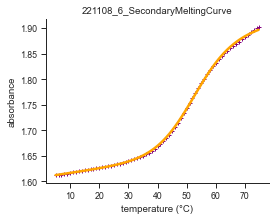

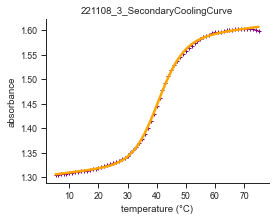

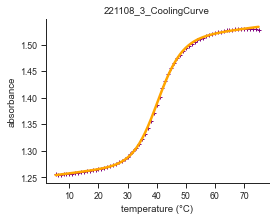

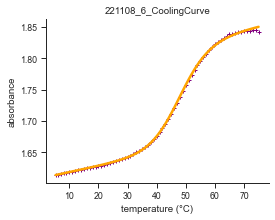

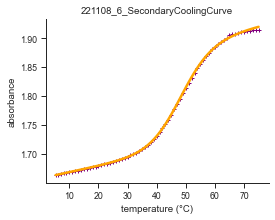

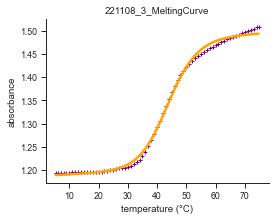

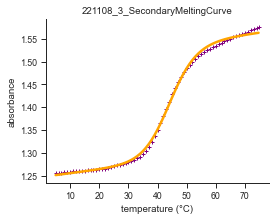

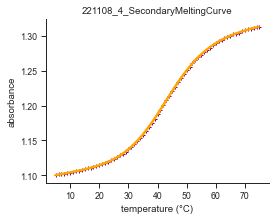

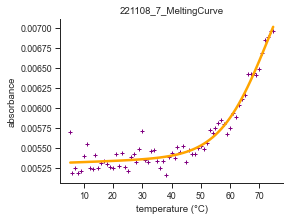

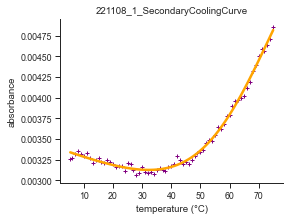

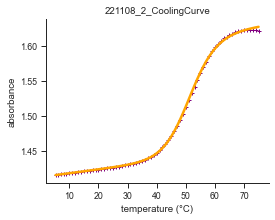

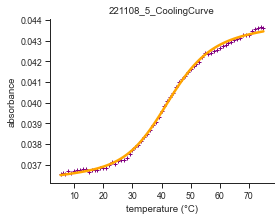

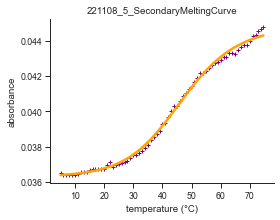

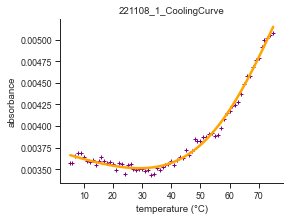

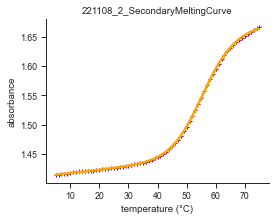

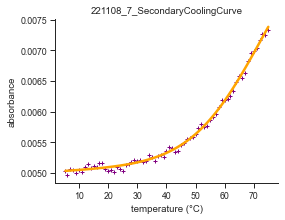

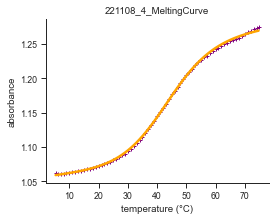

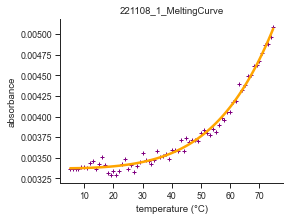

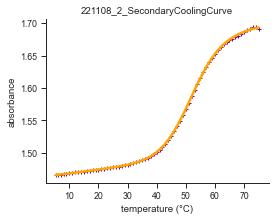

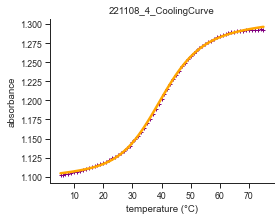

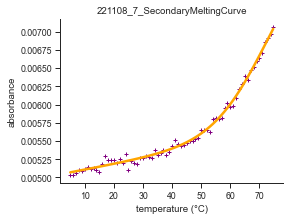

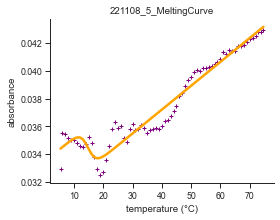

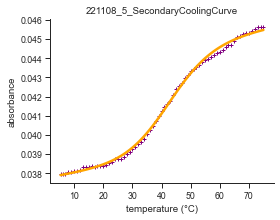

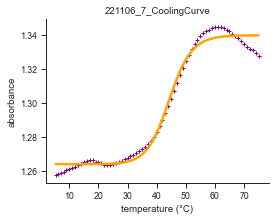

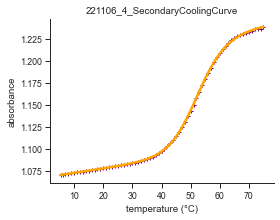

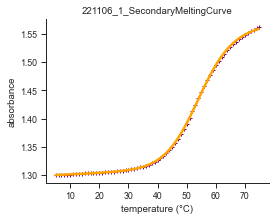

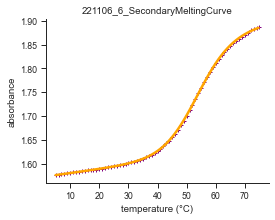

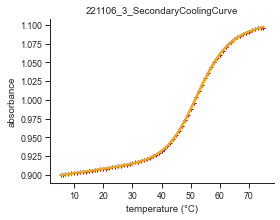

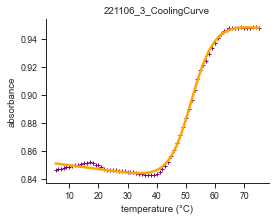

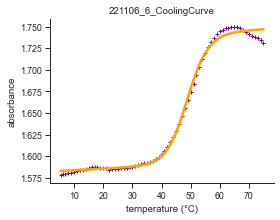

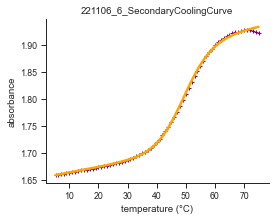

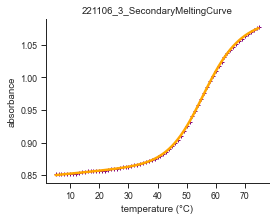

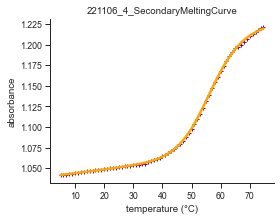

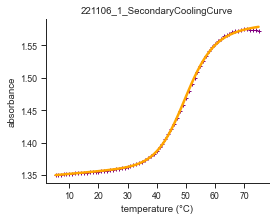

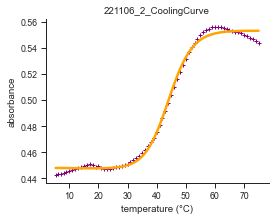

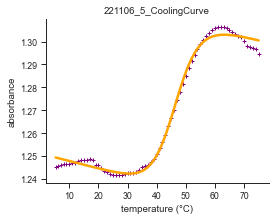

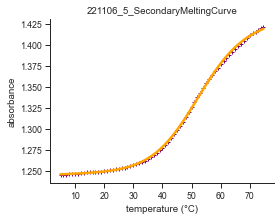

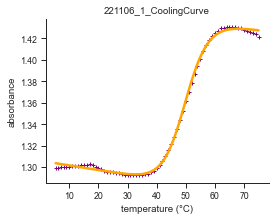

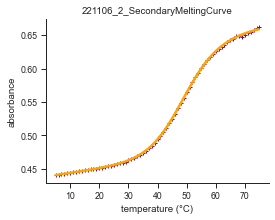

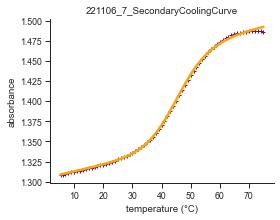

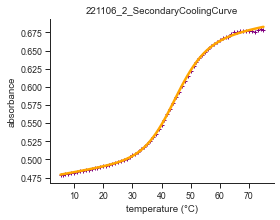

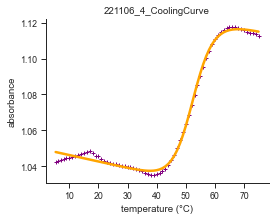

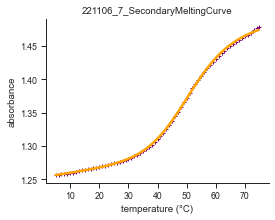

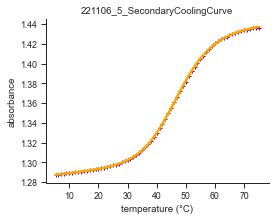

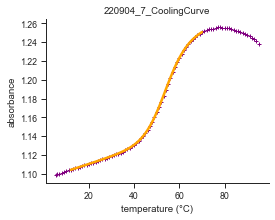

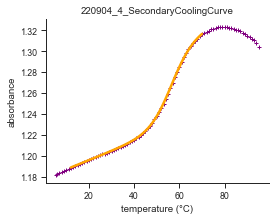

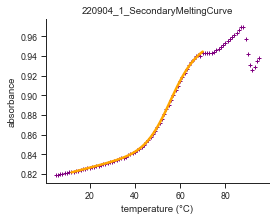

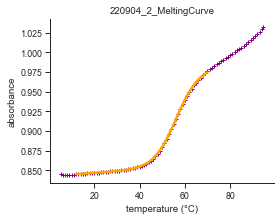

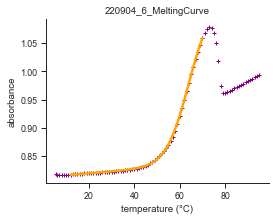

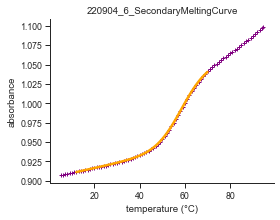

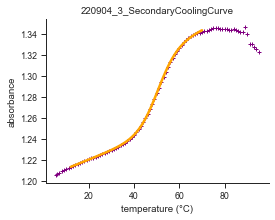

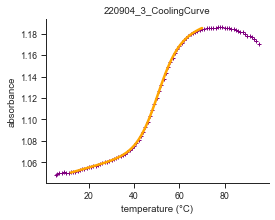

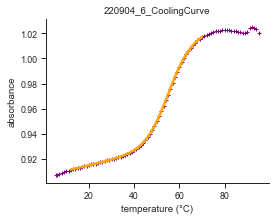

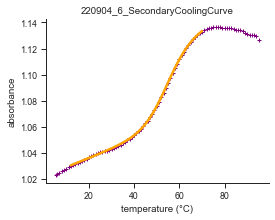

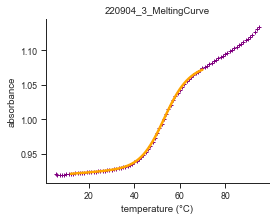

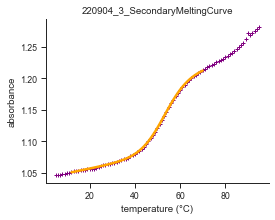

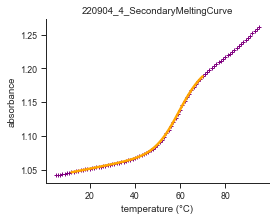

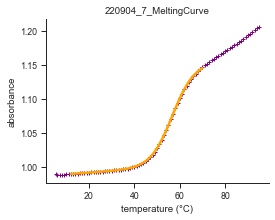

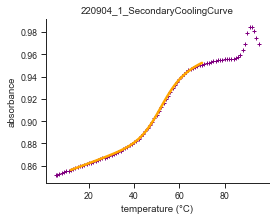

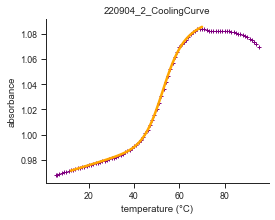

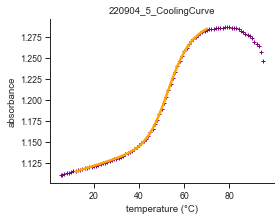

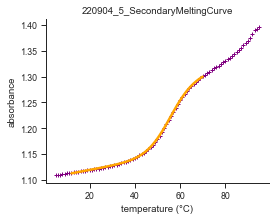

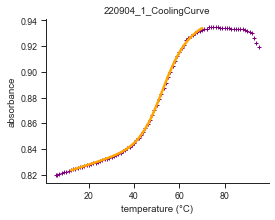

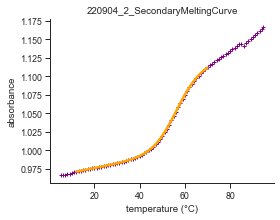

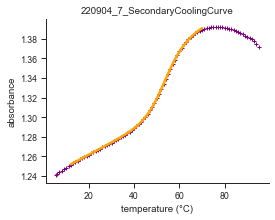

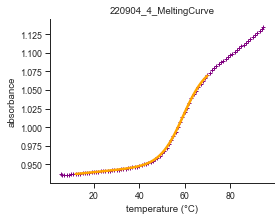

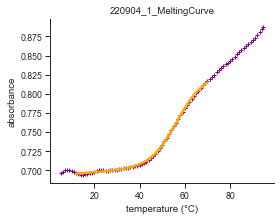

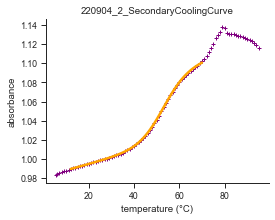

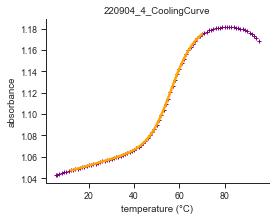

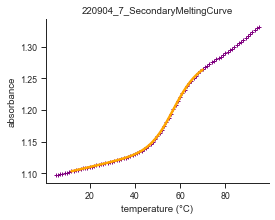

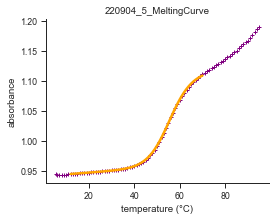

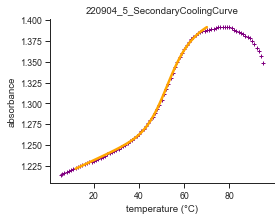

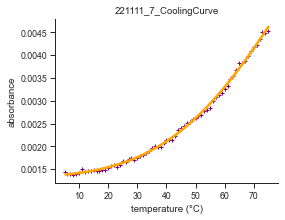

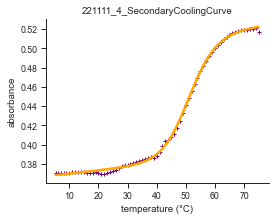

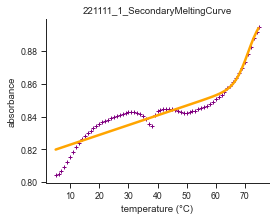

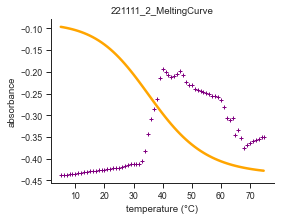

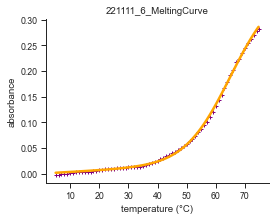

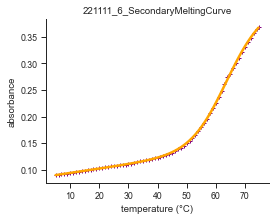

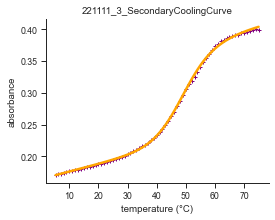

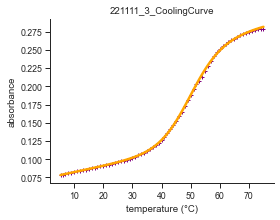

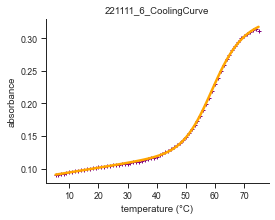

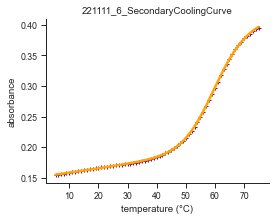

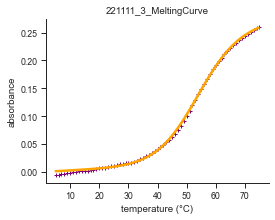

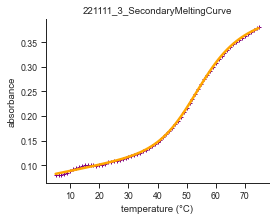

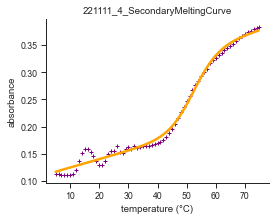

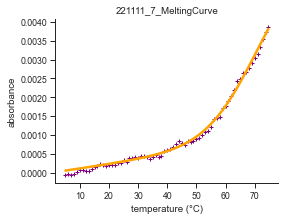

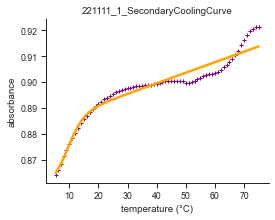

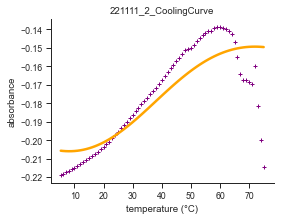

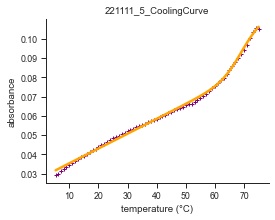

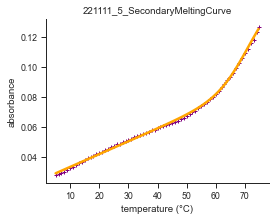

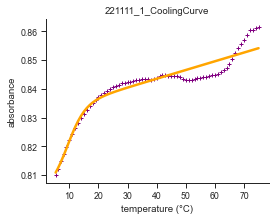

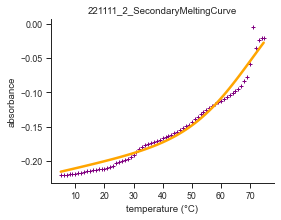

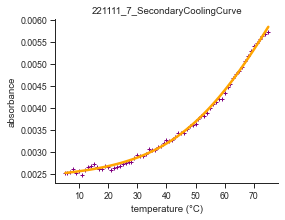

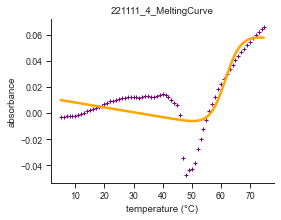

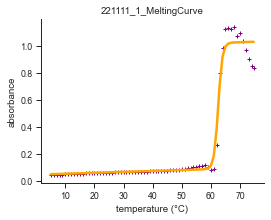

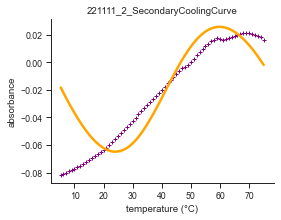

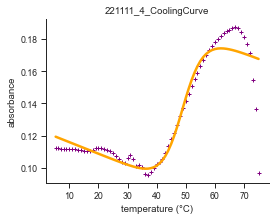

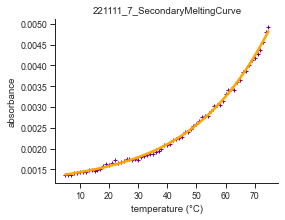

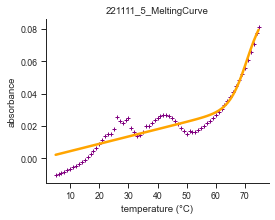

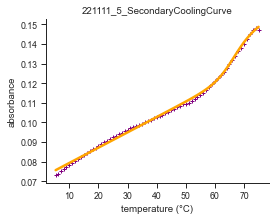

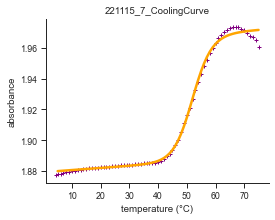

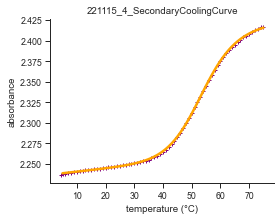

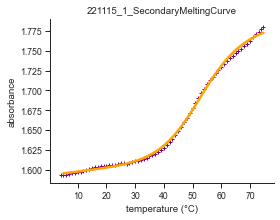

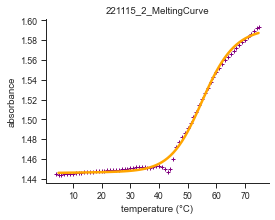

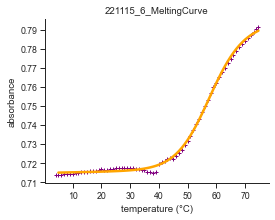

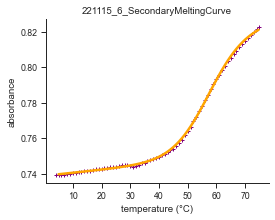

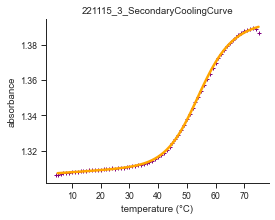

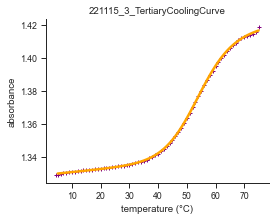

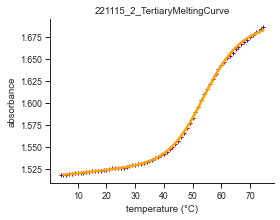

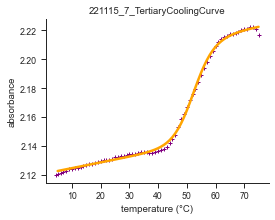

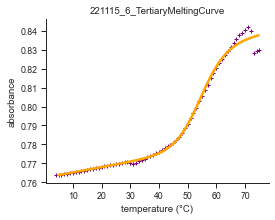

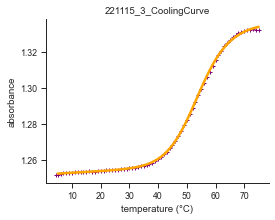

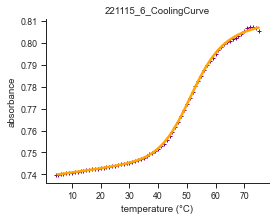

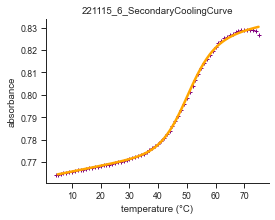

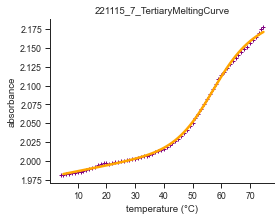

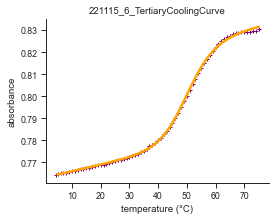

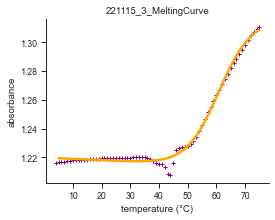

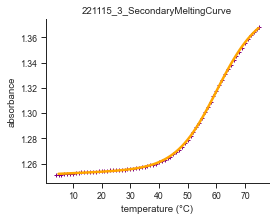

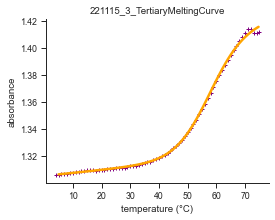

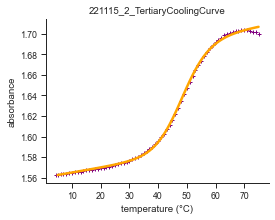

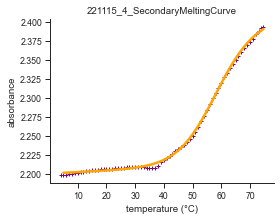

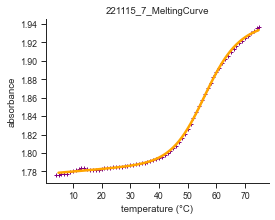

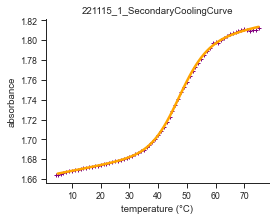

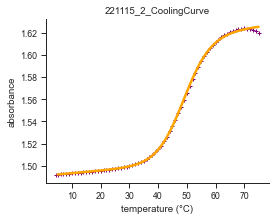

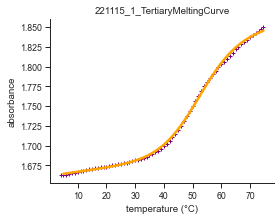

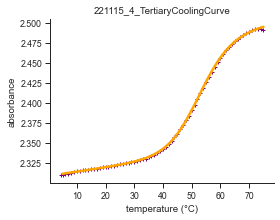

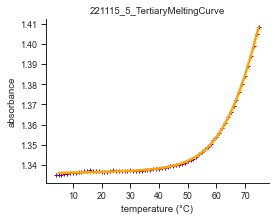

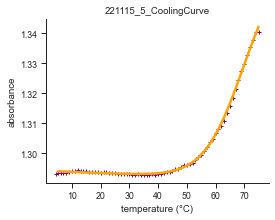

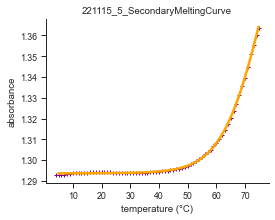

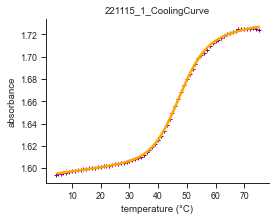

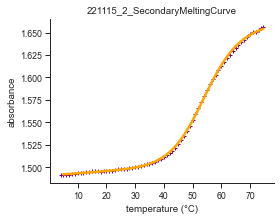

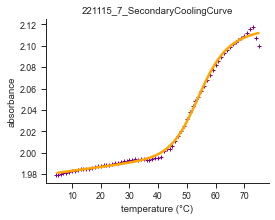

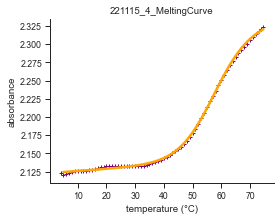

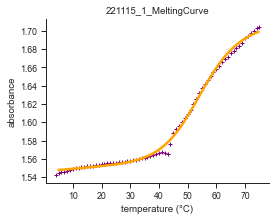

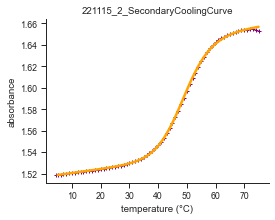

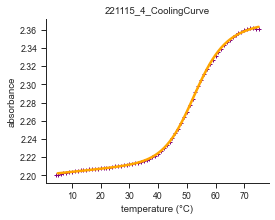

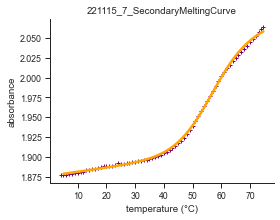

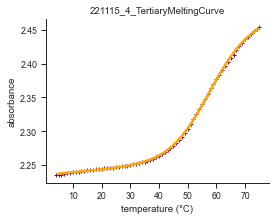

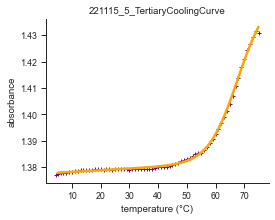

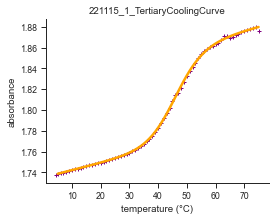

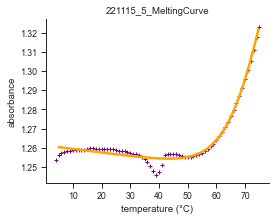

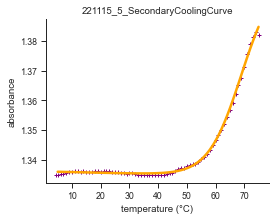

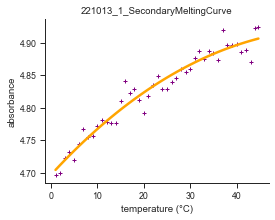

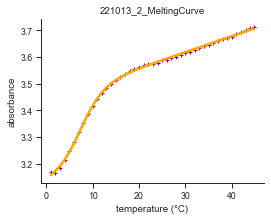

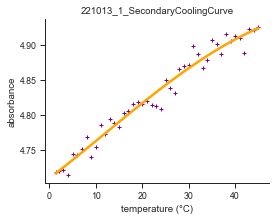

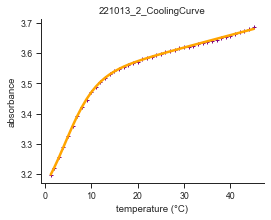

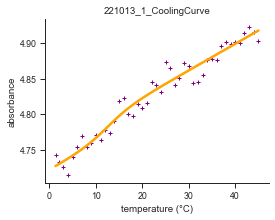

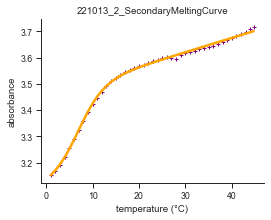

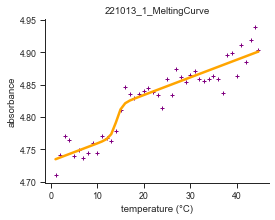

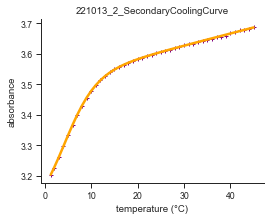

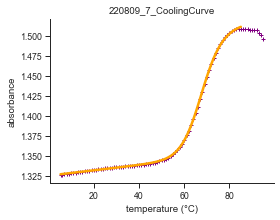

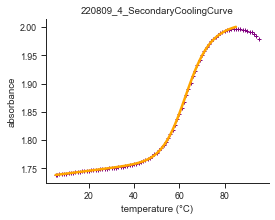

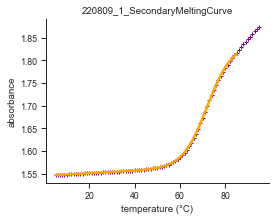

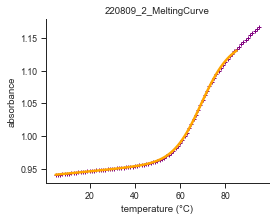

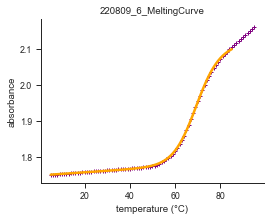

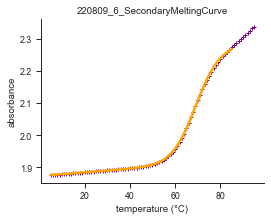

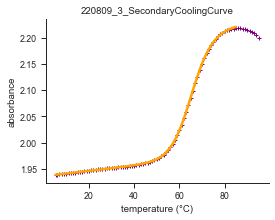

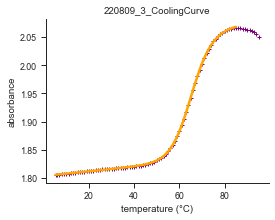

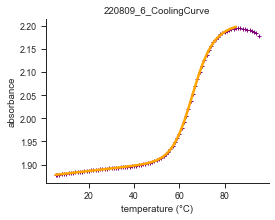

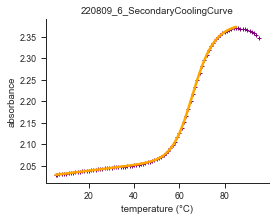

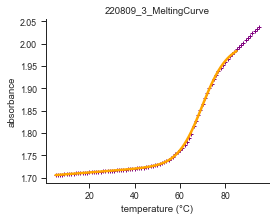

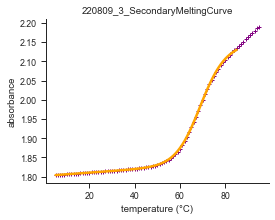

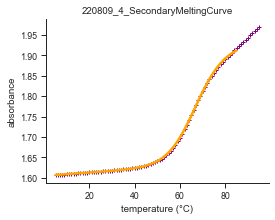

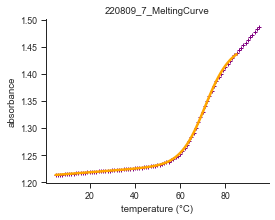

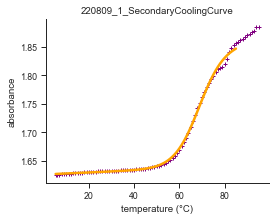

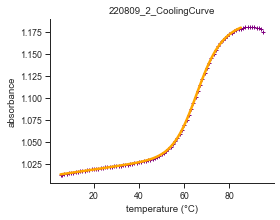

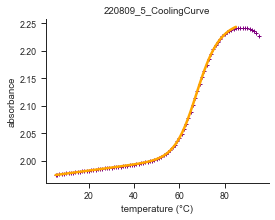

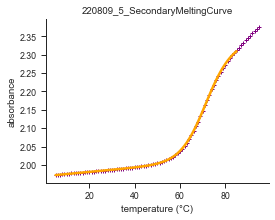

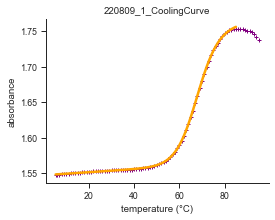

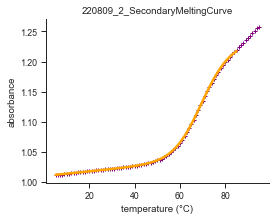

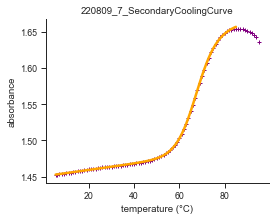

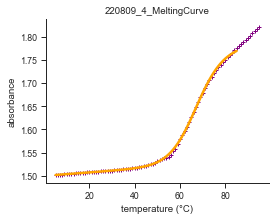

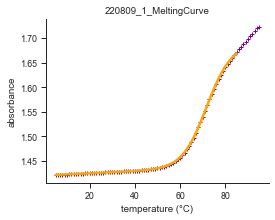

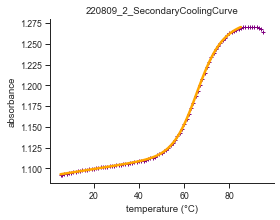

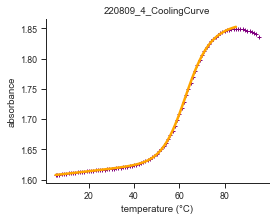

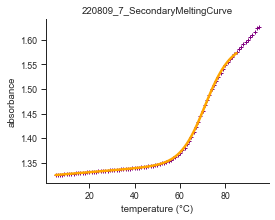

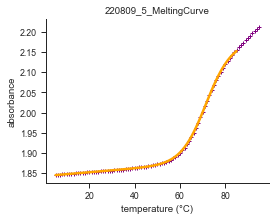

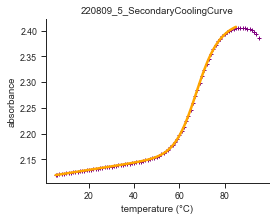

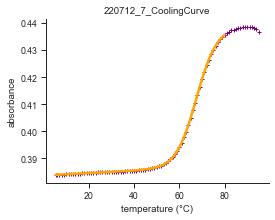

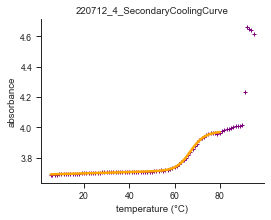

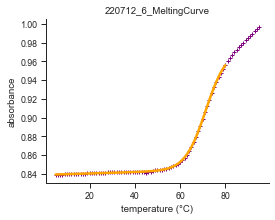

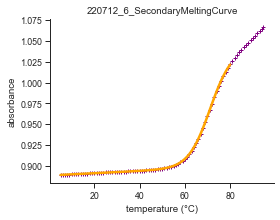

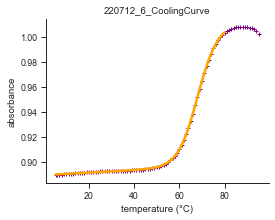

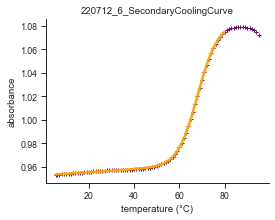

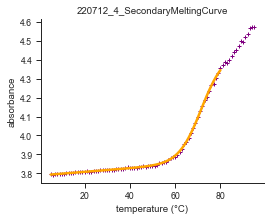

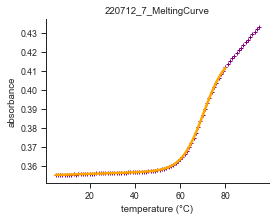

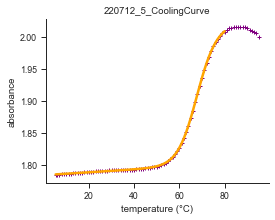

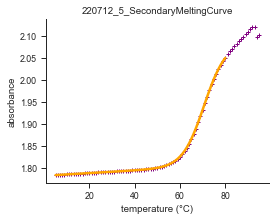

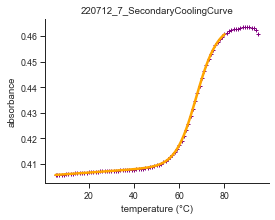

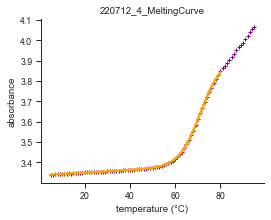

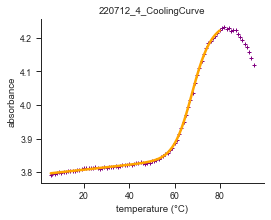

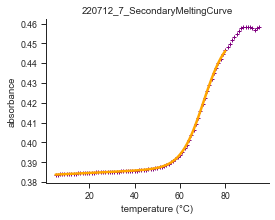

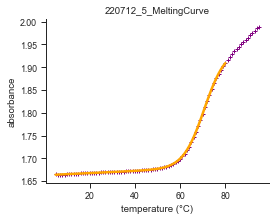

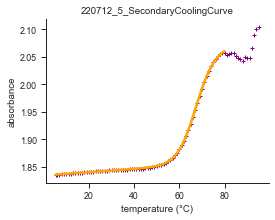

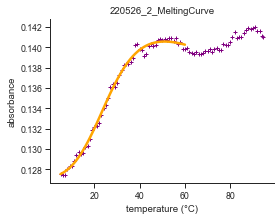

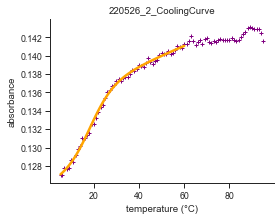

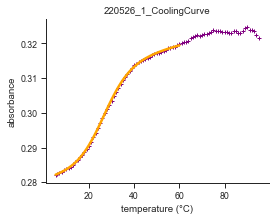

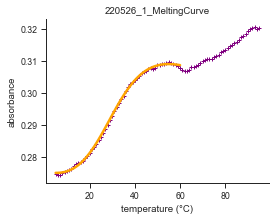

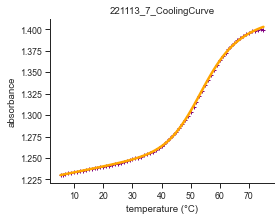

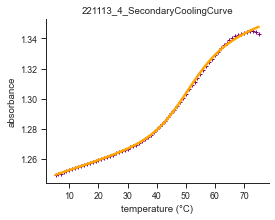

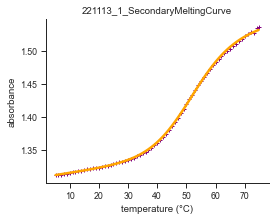

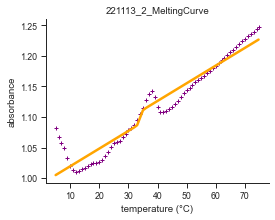

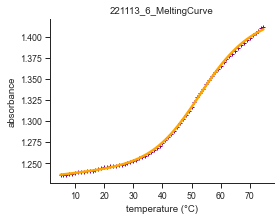

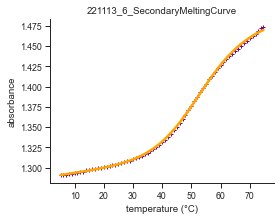

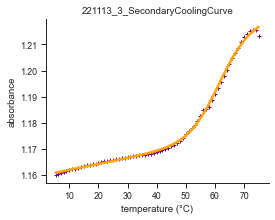

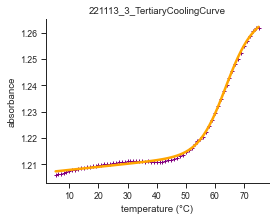

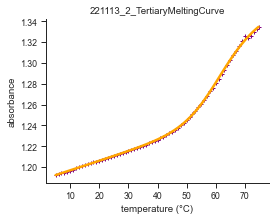

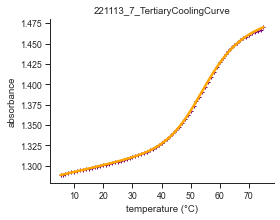

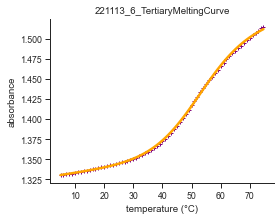

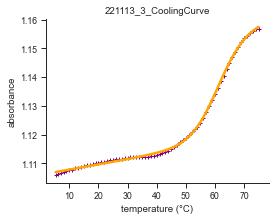

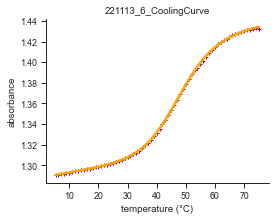

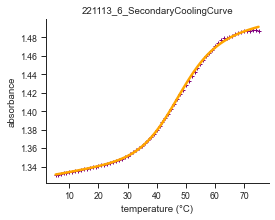

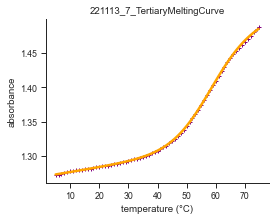

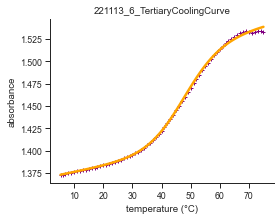

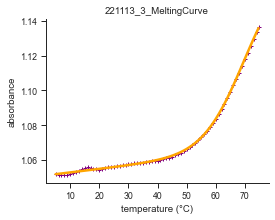

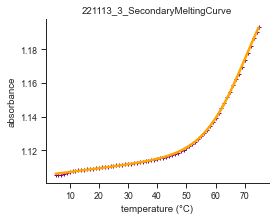

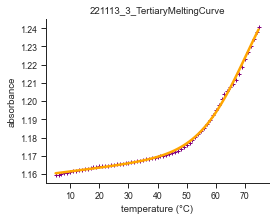

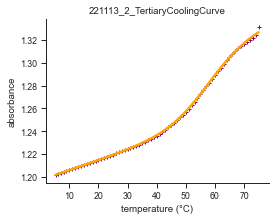

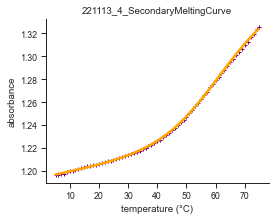

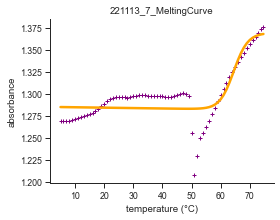

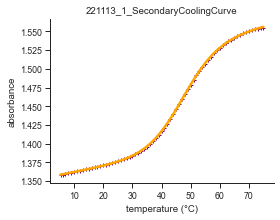

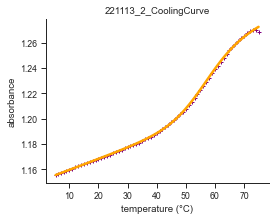

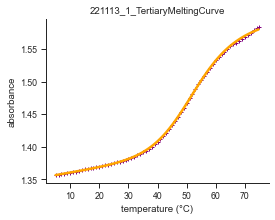

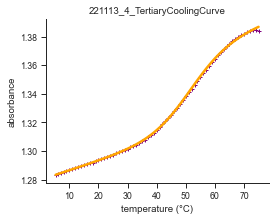

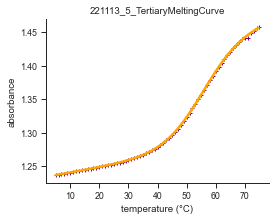

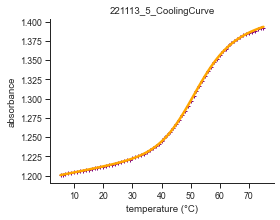

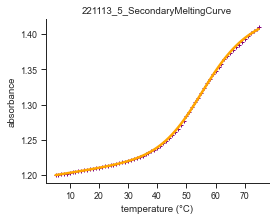

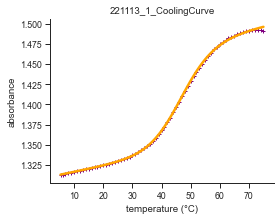

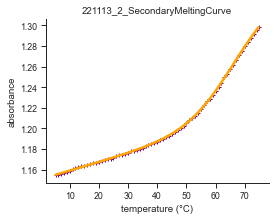

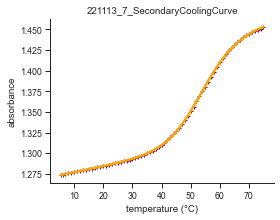

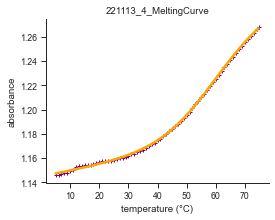

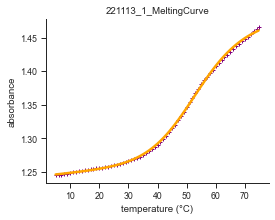

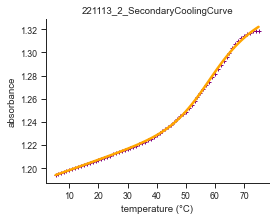

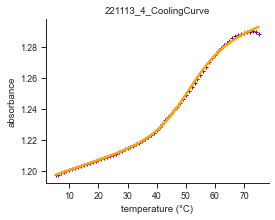

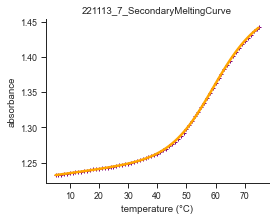

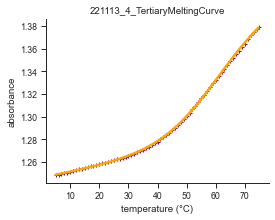

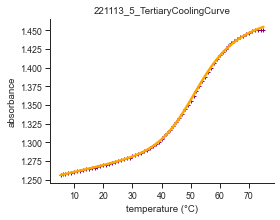

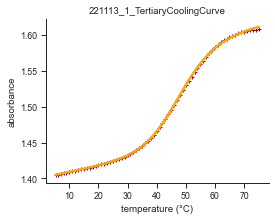

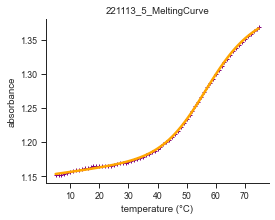

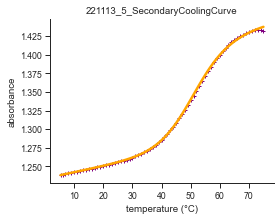

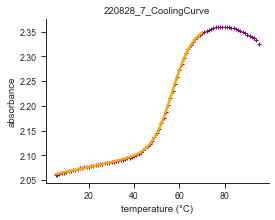

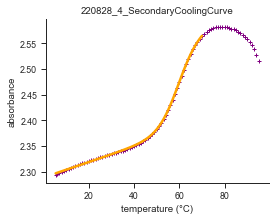

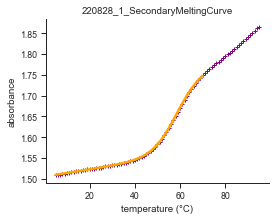

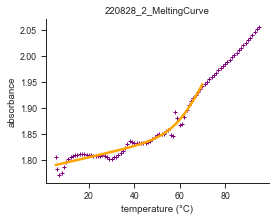

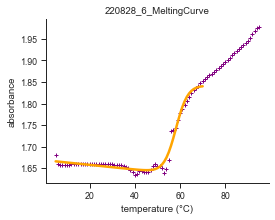

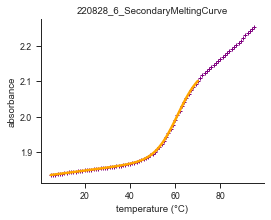

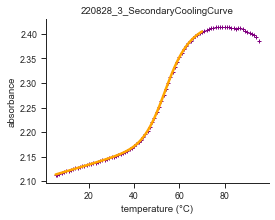

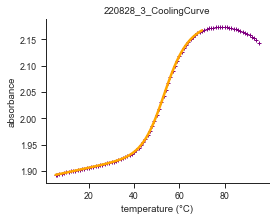

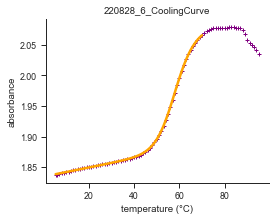

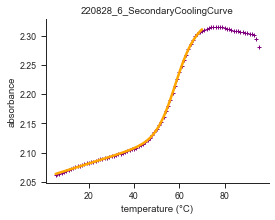

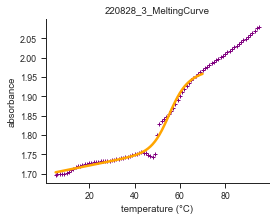

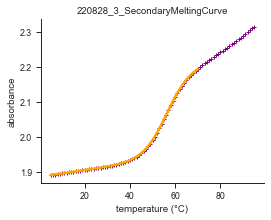

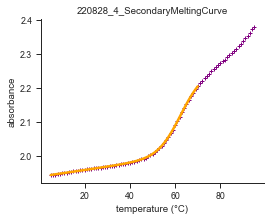

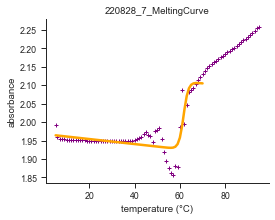

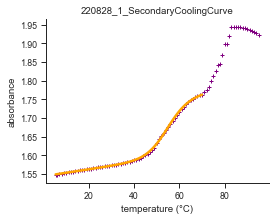

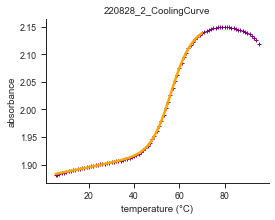

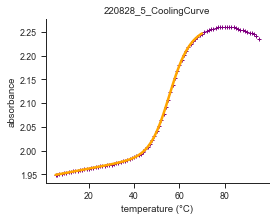

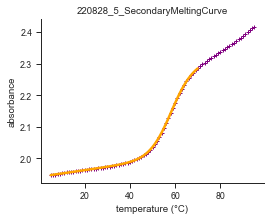

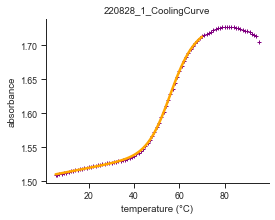

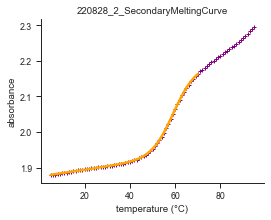

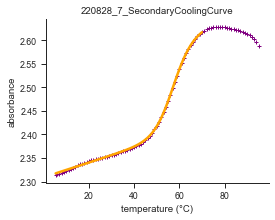

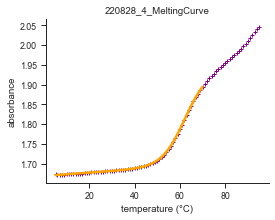

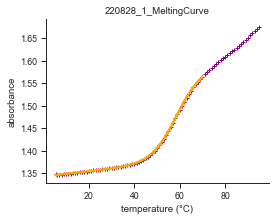

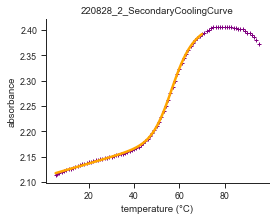

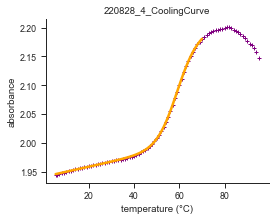

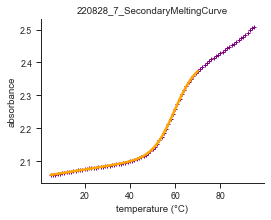

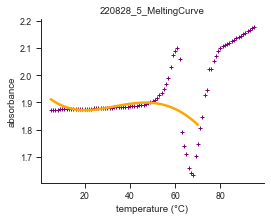

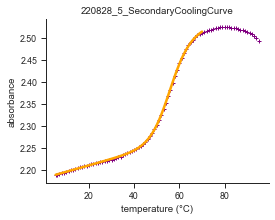

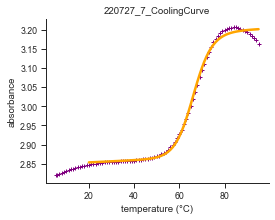

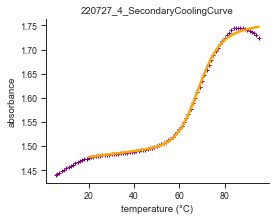

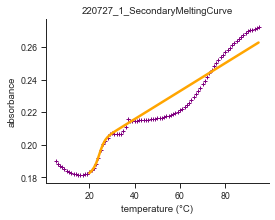

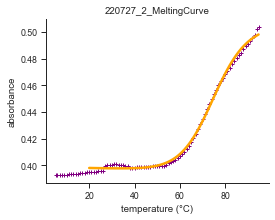

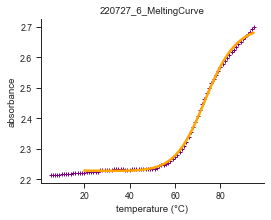

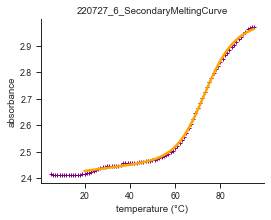

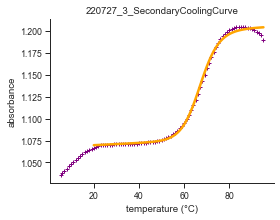

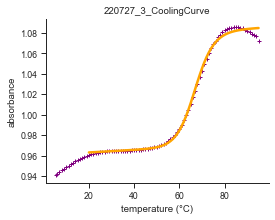

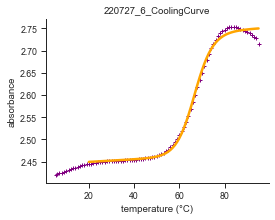

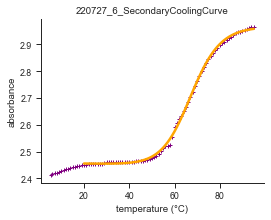

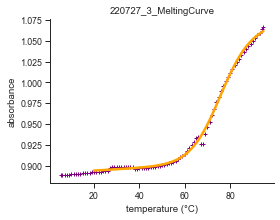

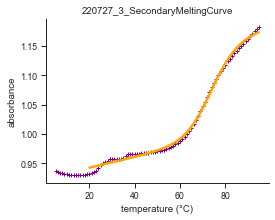

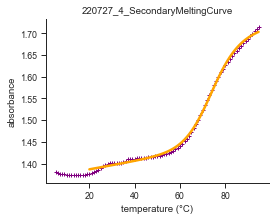

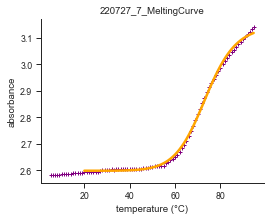

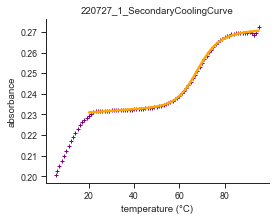

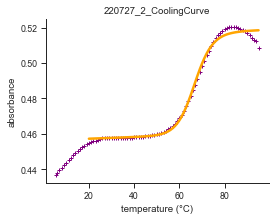

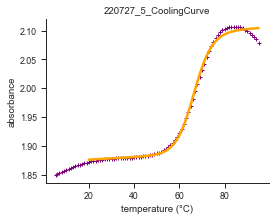

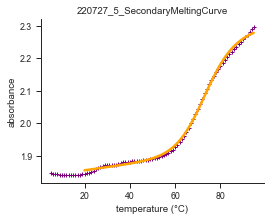

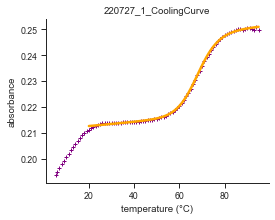

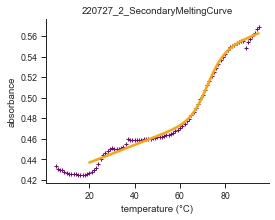

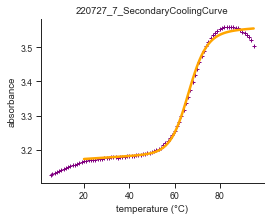

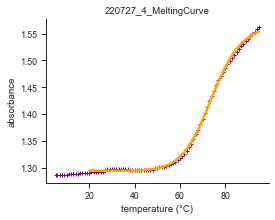

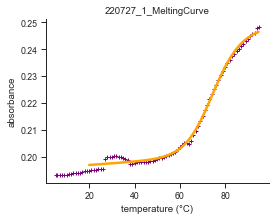

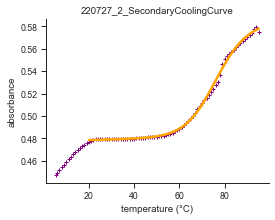

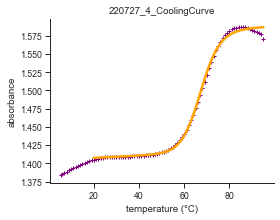

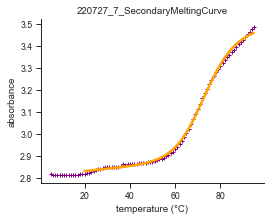

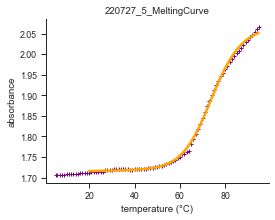

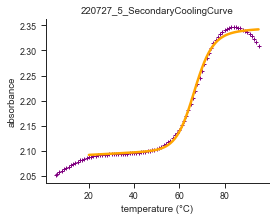

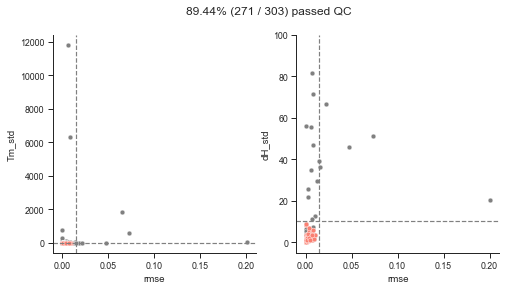

In [4]:
# Run fitting on all curves
result_df = fit_all(datadir="./data/uv_melt/ECLExport", 
                    sample_sheet_file=sample_sheet_file, 
                    result_file='./data/uv_melt/uvmelt_221116.csv')

In [269]:
# Or read from disk
result_df = pd.read_csv('./data/uv_melt/uvmelt_221110.csv', index_col=0).query('pass_qc')

Let's plot the curves that did not pass QC:

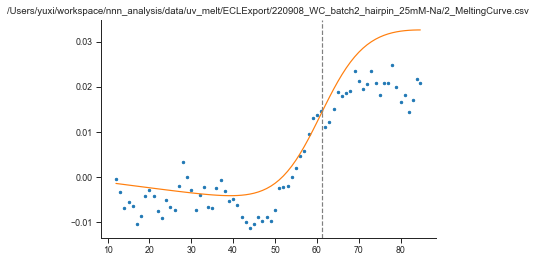

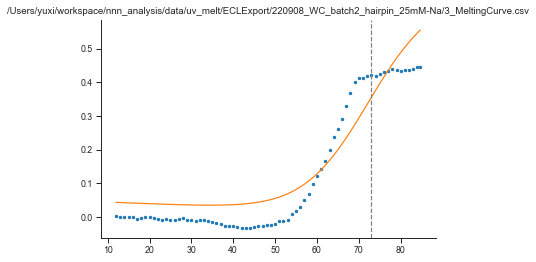

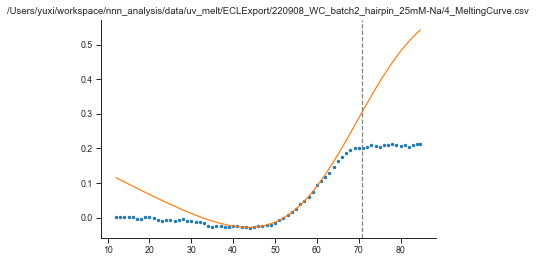

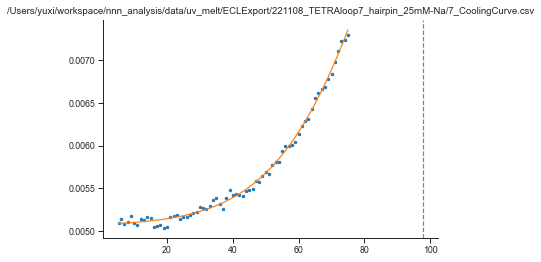

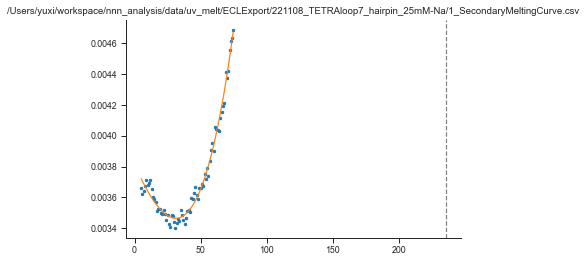

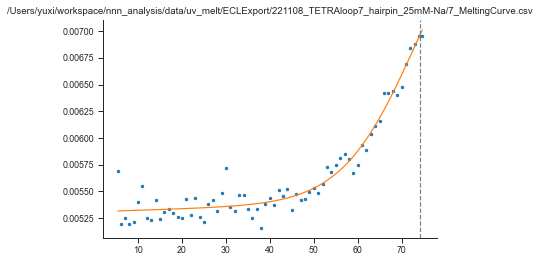

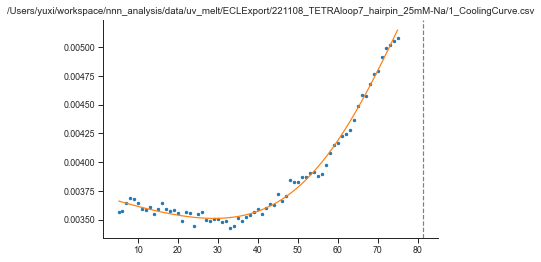

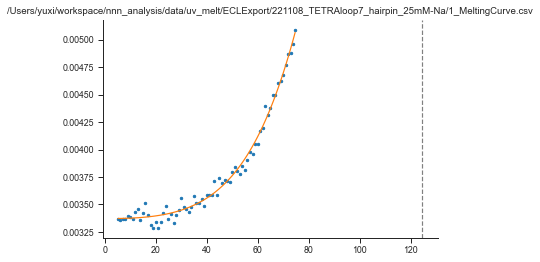

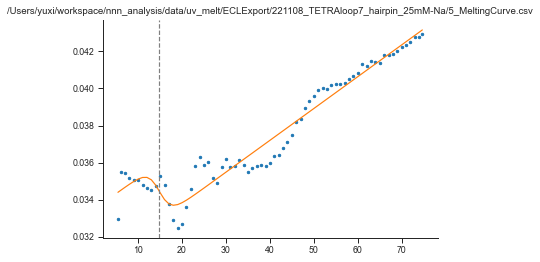

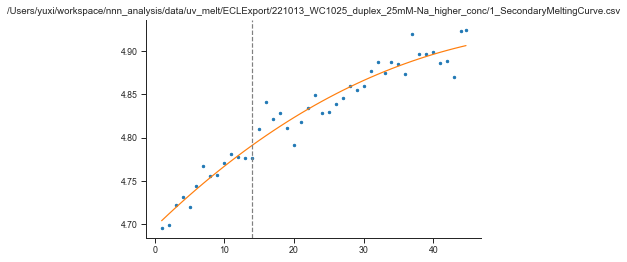

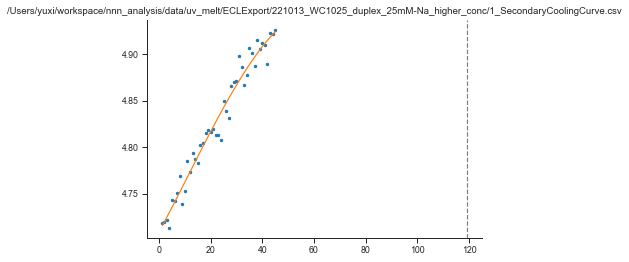

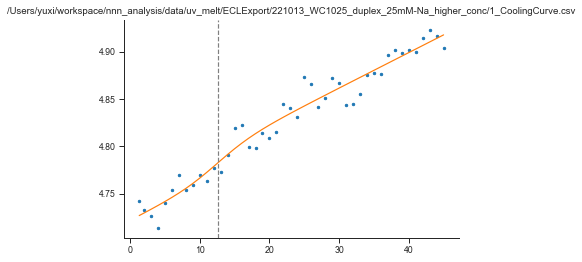

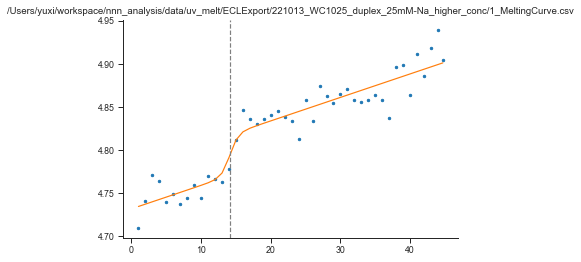

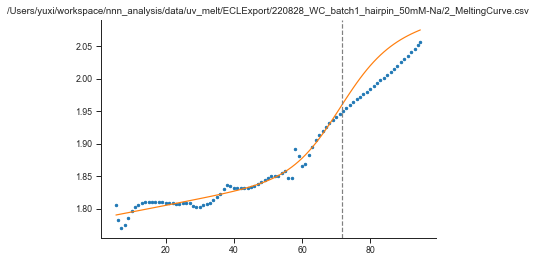

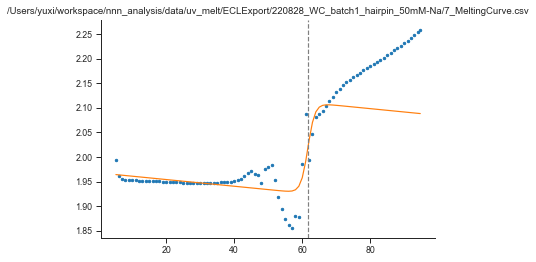

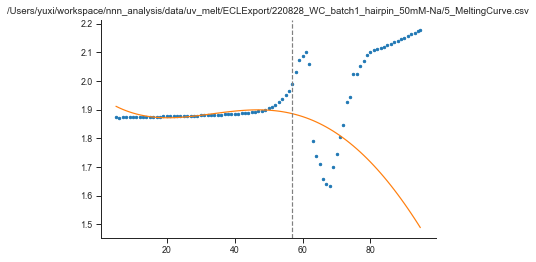

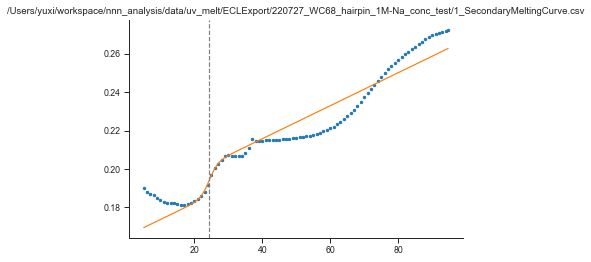

In [146]:
df = result_df.query('~pass_qc')
for i,row in df.iterrows():
    plot_curve_fit_result(row)

Now aggregate the results in the sample (different melt and cooling curves):

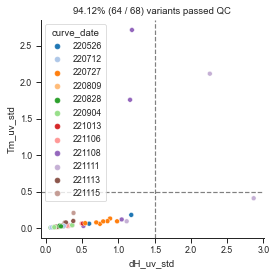

In [24]:
result_agg_df = agg_fit_result(uvmelt_result_file='./data/uv_melt/uvmelt_221116.csv',
                               agg_result_file='./data/uv_melt/uvmelt_agg_221116.csv',
                               sample_sheet_file=sample_sheet_file)

In [46]:
result_df.columns

Index(['curve_date', 'curve_num', 'curve_name', 'dH', 'dH_std', 'Tm', 'Tm_std',
       'fmax', 'fmax_std', 'fmin', 'fmin_std', 'slope', 'slope_std', 'rmse',
       'celsius_min', 'celsius_max', 'data_file', 'pass_qc', 'SEQID',
       'conc_uM', 'Na_mM', 'dG_37', 'dS'],
      dtype='object')

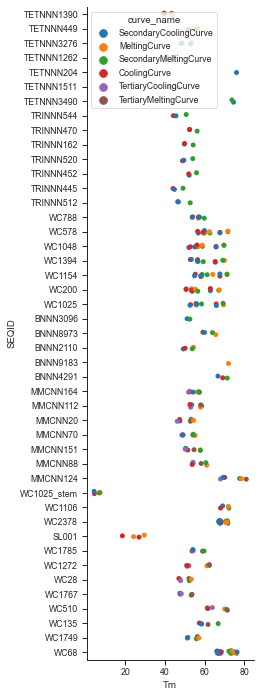

In [49]:
fig, ax = plt.subplots(figsize=(3,12))
sns.stripplot(data=result_df.query('pass_qc'), y='SEQID', x='Tm',hue='curve_name', palette='tab10')
sns.despine()

In [25]:
arr = pd.read_csv('./data/models/raw/arr_v0.csv', index_col=0)

df = result_agg_df.merge(arr, how='left', on='SEQID')

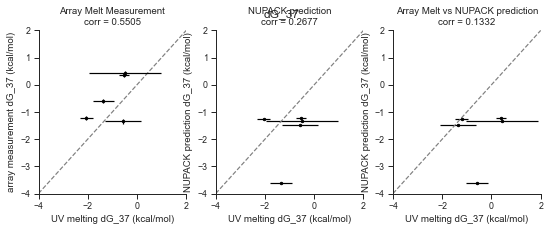

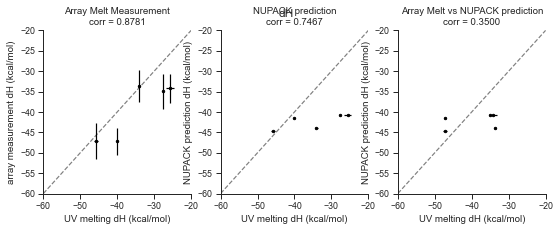

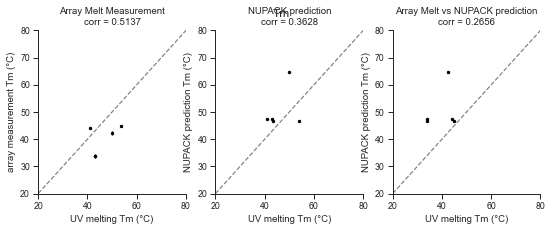

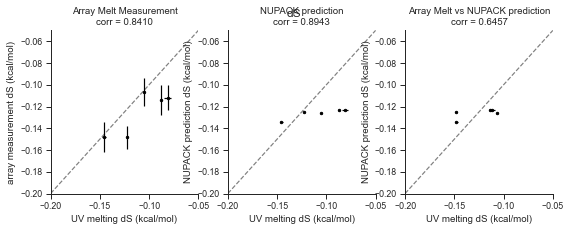

In [51]:
plot_query = 'Na_mM == 25 & is_hairpin & Series == "TETRAloop"'
df_q = df.query(plot_query)

def plot_uv_comparison(df_q, param, lim, array_suffix=''):
    unit_dict = dict(dH='kcal/mol', dS='kcal/mol', dG_37='kcal/mol', Tm='°C')
    unit = unit_dict[param]
    fig, ax = plt.subplots(1, 3, figsize=(9,3))
    ax[0].plot(lim, lim, '--', c='gray')
    ax[0].errorbar(df_q[param + '_uv'], df_q[param+array_suffix],
                   xerr=df_q[param+'_uv_std'], yerr=df_q[param+'_se'],
                   fmt='k.')
    ax[0].set_xlim(lim)
    ax[0].set_ylim(lim)
    ax[0].set_xlabel(f'UV melting {param} ({unit})')
    ax[0].set_ylabel(f'array measurement {param} ({unit})')
    ax[0].set_title('Array Melt Measurement\ncorr = %.4f' %
                    pearsonr(df_q[param + '_uv'], df_q[param+array_suffix])[0])

    ax[1].errorbar(df_q[param+'_uv'], df_q[param+'_NUPACK_salt_corrected'],
                   xerr=df_q[param+'_uv_std'],
                   fmt='k.')
    ax[1].plot(lim, lim, '--', c='gray')
    ax[1].set_xlim(lim)
    ax[1].set_ylim(lim)
    ax[1].set_xlabel(f'UV melting {param} ({unit})')
    ax[1].set_ylabel(f'NUPACK prediction {param} ({unit})')
    ax[1].set_title('NUPACK prediction\ncorr = %.4f' %
                    pearsonr(df_q[param+'_uv'], df_q[param+'_NUPACK_salt_corrected'])[0])

    x = df_q[param+array_suffix]
    y = df_q[param+'_NUPACK_salt_corrected']
    ax[2].errorbar(x, y,
               xerr=df_q[param+'_uv_std'],
               fmt='k.')
    ax[2].plot(lim, lim, '--', c='gray')
    ax[2].set_xlim(lim)
    ax[2].set_ylim(lim)
    ax[2].set_xlabel(f'UV melting {param} ({unit})')
    ax[2].set_ylabel(f'NUPACK prediction {param} ({unit})')
    ax[2].set_title('Array Melt vs NUPACK prediction\ncorr = %.4f' %
                    pearsonr(x, y)[0])
    
    plt.suptitle(param)
    sns.despine()
    plt.show()
    
plot_uv_comparison(df_q, 'dG_37', lim = (-4, 2))
plot_uv_comparison(df_q, 'dH', lim = (-60, -20))
plot_uv_comparison(df_q, 'Tm', lim = (20, 80))
plot_uv_comparison(df_q, 'dS', lim = (-.2, -.05))

In [413]:
plot_query = 'Na_mM == 25 & is_hairpin'
df_q = df.query(plot_query)

ols_Tm = fit_param_offset(df_q, 'Tm', fix_slope=True, adjusted=False)
ols_dG_37 = fit_param_offset(df_q, 'dG_37', fix_slope=True, adjusted=False)
ols_dH = fit_param_offset(df_q, 'dH', fix_slope=True, adjusted=False)
ols_dS = fit_param_offset(df_q, 'dS', fix_slope=True, adjusted=False)
print(ols_Tm.coef_, ols_dG_37.coef_, ols_dH.coef_, ols_dS.coef_)
correction = dict(Tm=ols_Tm.coef_, dG_37=ols_dG_37.coef_)

fileio.write_pickle(correction, './data/uv_melt/correction.pkl')

[ 1.        12.6771236] [ 1.         -1.13626671] [1.         2.74880351] [1.         0.01283626]


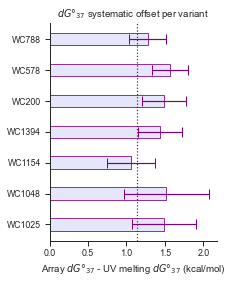

In [405]:
# correction = fileio.read_pickle('./data/uv_melt/correction.pkl')

plot_query = 'Na_mM == 25 & is_hairpin & (Series == "WatsonCrick")'
df_q = df.query(plot_query)

plt.figure(figsize=(3, 4))
plt.barh(df_q['SEQID'], df_q['dG_37'] - df_q['dG_37_uv'], 
        xerr=df_q['dG_37_se'] + df_q['dG_37_uv_std'],
        fc='lavender', height=0.4, edgecolor='purple', ecolor='purple', capsize=5)
plt.axvline(x=-correction['dG_37'][1], c='purple', linestyle=':')
plt.xlabel(r'Array $dG°_{37}$ - UV melting $dG°_{37}$ (kcal/mol)')
plt.title(r'$dG°_{37}$ systematic offset per variant')
sns.despine()
util.save_fig('./fig/UV_melt/dG_37_offset_per_variant_new.pdf')

In [418]:
p = 'Tm'
arr[p+'_corrected'] = correct_param(arr, correction, p)
arr['dG_37_corrected'] = util.get_dG(dH=arr.dH, Tm=arr.Tm_corrected, celsius=37)

plotting.plot_colored_scatter_comparison(data=arr, x='dG_37', y='dG_37_corrected', lim=(-7, 3))

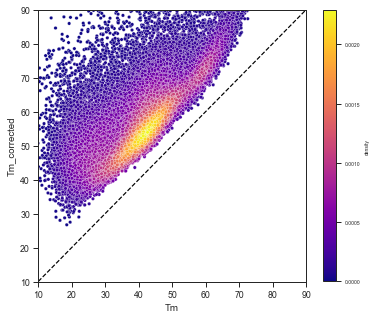

In [442]:
p = 'dG_37'
arr[p+'_corrected'] = correct_param(arr, correction, p)
arr['Tm_corrected'] = (C2T + 37) / (1 - arr.dG_37_corrected / arr.dH) - C2T

plotting.plot_colored_scatter_comparison(data=arr, x='Tm', y='Tm_corrected', lim=(10, 90))

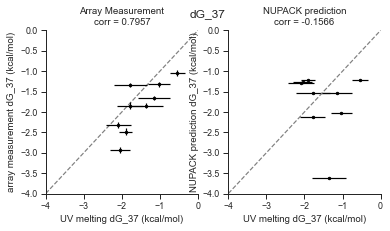

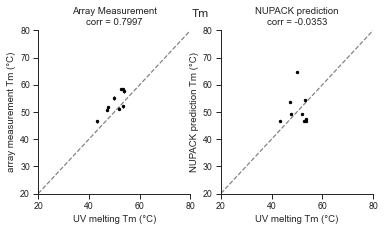

In [439]:
# Only correct Tm
arr = pd.read_csv('./data/models/raw/arr_v0.csv', index_col=0)
p = 'Tm'
arr[p+'_corrected'] = correct_param(arr, correction, p)
arr['dG_37_corrected'] = util.get_dG(dH=arr.dH, Tm=arr.Tm_corrected, celsius=37)
df = result_agg_df.merge(arr, how='left', on='SEQID')

plot_query = 'Na_mM == 25 & is_hairpin & dG_37_uv_std < 0.5  & (Series != "WatsonCrick")'
# plot_query = 'Na_mM == 25 & is_hairpin & dG_37_uv_std < 0.5'
df_q = df.query(plot_query)

plot_uv_comparison(df_q, 'dG_37', lim = (-4, -0), array_suffix='_corrected')
plot_uv_comparison(df_q, 'Tm', lim = (20, 80), array_suffix='_corrected')

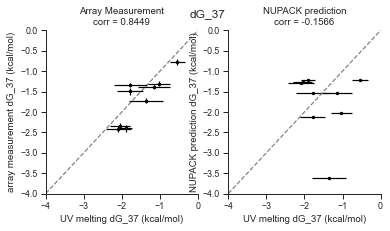

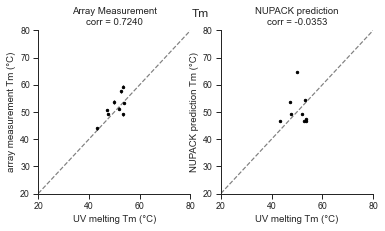

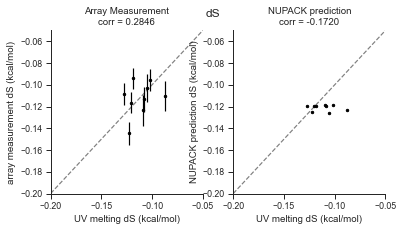

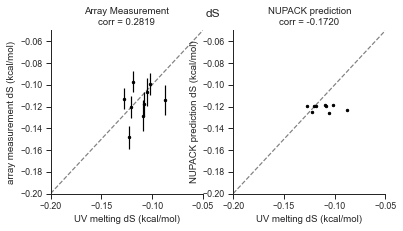

In [448]:
# Only correct dG_37
arr = pd.read_csv('./data/models/raw/arr_v0.csv', index_col=0)
p = 'dG_37'
arr[p+'_corrected'] = correct_param(arr, correction, p)
arr['Tm_corrected'] = (C2T + 37) / (1 - arr.dG_37_corrected / arr.dH) - C2T
arr['dS_corrected'] = arr.dH / (arr.Tm_corrected + C2T)
df = result_agg_df.merge(arr, how='left', on='SEQID')
plot_query = 'Na_mM == 25 & is_hairpin & dG_37_uv_std < 0.5  & (Series != "WatsonCrick")'
# plot_query = 'Na_mM == 25 & is_hairpin & dG_37_uv_std < 0.5'
df_q = df.query(plot_query)

plot_uv_comparison(df_q, 'dG_37', lim = (-4, -0), array_suffix='_corrected')
plot_uv_comparison(df_q, 'Tm', lim = (20, 80), array_suffix='_corrected')
plot_uv_comparison(df_q, 'dS', lim = (-.2, -.05), array_suffix='_corrected')
plot_uv_comparison(df_q, 'dS', lim = (-.2, -.05))

Correcting dG_37 only makes more sense to me. Let's apply the correction and save to file, both with col name suffix and overwriting the uncorrected values in place.

In [449]:
arr = pd.read_csv('./data/models/raw/arr.csv', index_col=0)
p = 'dG_37'
arr[p+'_corrected'] = correct_param(arr, correction, p)
arr['Tm_corrected'] = (C2T + 37) / (1 - arr.dG_37_corrected / arr.dH) - C2T
arr['dS_corrected'] = arr.dH / (arr.Tm_corrected + C2T)

arr.to_csv('./data/models/raw/arr_corrected.csv')

In [450]:
arr = pd.read_csv('./data/models/raw/arr.csv', index_col=0)
p = 'dG_37'
arr[p] = correct_param(arr, correction, p)
arr['Tm'] = (C2T + 37) / (1 - arr.dG_37 / arr.dH) - C2T
arr['dS'] = arr.dH / (arr.Tm + C2T)

arr.to_csv('./data/models/raw/arr_corrected_inplace.csv')

In [451]:
arr = pd.read_csv('./data/models/raw/arr_corrected_inplace.csv', index_col=0)